In [1]:
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
a = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
fpath =OrderedDict()
tree = OrderedDict()


start_t = time.time()



isData = 0

ntupler_version = 'V1p17/'
analyzer_version = "/v1/v86/"
#     analyzer_version = "/v1/v95/"
analyzer_version = "/v1/v100/"
analyzer_version = "/v1/v110/" #new acceptance definition

#     analyzer_version = "/v1/v110/" #new acceptance definition and no cuts at all


decay = '4Tau'
mass = ['7', '15', '40','55']
ctaus  = ['100','1000','10000','100000']
# ctaus = ['10']
for ct in ctaus:
    for m in mass:
        mc_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/MC_all/'+analyzer_version+'/normalized/'
        fpath['m'+m+'ctau'+ct] = mc_path + 'ggH_HToSSTo'+decay+'_MH-125_MS-'+str(m)+'_ctau-'+ct+'_137000pb_weighted.root'

for k,v in fpath.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree[k] = root_dir['MuonSystem']
   



m7ctau100 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v110//normalized/ggH_HToSSTo4Tau_MH-125_MS-7_ctau-100_137000pb_weighted.root
m15ctau100 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v110//normalized/ggH_HToSSTo4Tau_MH-125_MS-15_ctau-100_137000pb_weighted.root
m40ctau100 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v110//normalized/ggH_HToSSTo4Tau_MH-125_MS-40_ctau-100_137000pb_weighted.root
m55ctau100 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v110//normalized/ggH_HToSSTo4Tau_MH-125_MS-55_ctau-100_137000pb_weighted.root
m7ctau1000 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17//MC_all//v1/v110//normalized/ggH_HToSSTo4Tau_MH-125_MS-7_ctau-1000_137000pb_weighted.root
m15ctau1000 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuon

In [3]:
acceptance = {}
sel_ev = {}
accep_met = {}
for k, T in tree.items():
    weight = T.array('weight')*T.array('higgsPtWeight')
    sel_ev[k] = np.sum(T.array('gLLP_csc'),axis = 1) >= 1
    acceptance[k] = np.sum((T.array('weight')*T.array('higgsPtWeight'))[sel_ev[k]])/np.sum(T.array('weight'))
    
    
    sel_ev[k] = np.logical_and(sel_ev[k], np.logical_and(T.array('metEENoise')>=200 ,T.array('METNoMuTrigger')))

    accep_met[k] = np.sum((weight)[sel_ev[k]])/np.sum(T.array('weight'))
    print(k,acceptance[k],accep_met[k])

m7ctau100 0.10658804 0.0017914091
m15ctau100 0.026883777 0.0008964388
m40ctau100 0.0008779927 0.00010956524
m55ctau100 0.00013081737 2.6699092e-05
m7ctau1000 0.23360409 0.0021630244
m15ctau1000 0.27517748 0.0025555047
m40ctau1000 0.17088455 0.0022954948
m55ctau1000 0.083737075 0.0018755246
m7ctau10000 0.045203414 0.00045393055
m15ctau10000 0.08996624 0.0008723049
m40ctau10000 0.20388415 0.0016170067
m55ctau10000 0.23915209 0.0017276726
m7ctau100000 0.0049763606 4.8171165e-05
m15ctau100000 0.010840262 0.000105216925
m40ctau100000 0.033288155 0.00022506119
m55ctau100000 0.052708834 0.00024617912


In [10]:
acceptance

{'m7ctau100': 0.10658804,
 'm15ctau100': 0.026883777,
 'm40ctau100': 0.0008779927,
 'm55ctau100': 0.00013081737,
 'm7ctau1000': 0.23360409,
 'm15ctau1000': 0.27517748,
 'm40ctau1000': 0.17088455,
 'm55ctau1000': 0.083737075,
 'm7ctau10000': 0.045203414,
 'm15ctau10000': 0.08996624,
 'm40ctau10000': 0.20388415,
 'm55ctau10000': 0.23915209,
 'm7ctau100000': 0.0049763606,
 'm15ctau100000': 0.010840262,
 'm40ctau100000': 0.033288155,
 'm55ctau100000': 0.052708834}

# Plots

In [56]:
ctaus = ['100','1000','10000','100000']

[   100   1000  10000 100000]
[   100   1000  10000 100000]
[   100   1000  10000 100000]
[   100   1000  10000 100000]


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


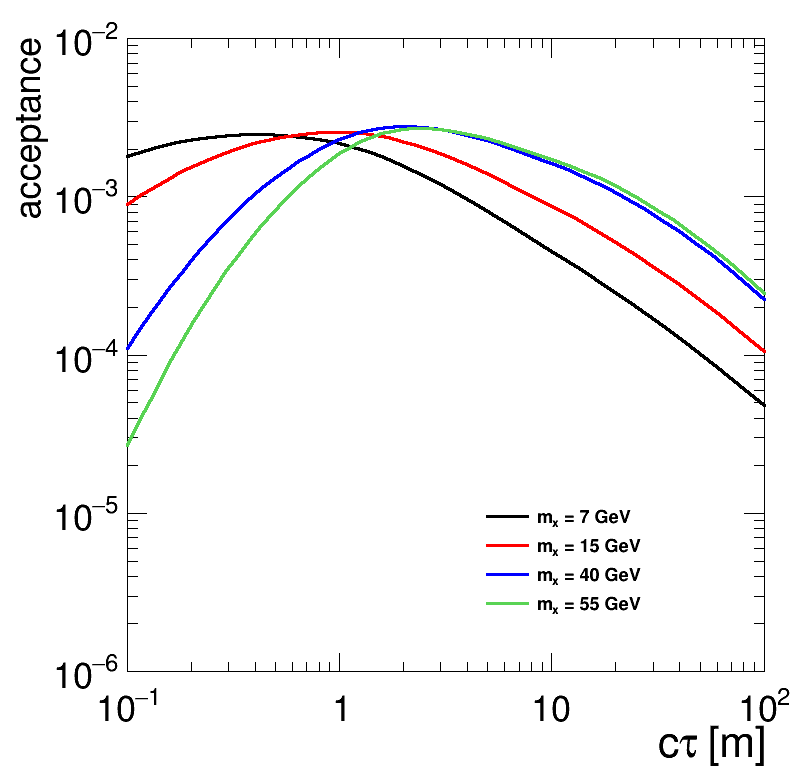

In [9]:
import os


leg = rt.TLegend(0.6,0.2,0.9,0.35)

leg.SetTextSize(0.025)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
c.SetRightMargin(0.04)


rt.gStyle.SetOptFit(1011)
h = {}





for i, m in enumerate(mass):
    var = acceptance
    var = accep_met
    y = np.array([var['m'+m+'ctau100'], var['m'+m+'ctau1000'], var['m'+m+'ctau10000'], var['m'+m+'ctau100000']])
    x = np.array([int(a) for a in ctaus])
#     cond = y>0.0
    print(x)
    h[m] = create_TGraph(x/1000.0, y,  axis_title=['c#tau [m]', 'acceptance'])

   
    h[m].SetLineColor(std_color_list[i])
    h[m].SetLineWidth(3)

    h[m].GetXaxis().SetTitleOffset(1)
    h[m].GetYaxis().SetTitleSize(0.05)
    h[m].GetYaxis().SetTitleOffset(1.5)

    h[m].GetXaxis().SetLimits(0.1,100.0)
    h[m].GetYaxis().SetRangeUser(0.000001,0.01)
    leg.AddEntry(h[m], "m_{x} = "+str(m)+" GeV", "L")


for i,m in enumerate(h.keys()):
    h[m].Draw('CA' if i == 0 else 'Csame')
#     h[m].Draw('LA' if i == 0 else 'Lsame')




tdrstyle.setTDRStyle()
# CMS_lumi.cmsText     = "CMS"
# iPos = 0
# CMS_lumi.writeExtraText = True
# CMS_lumi.extraText   = "Preliminary"

# if( iPos==0 ): CMS_lumi.relPosX = 0.12
# CMS_lumi.CMS_lumi(c, 4, iPos)




leg.Draw()
c.SetLogy()
c.SetLogx()
c.SetTicky(1)
c.SetTickx(1)
# output_dir = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits/'+version+bdt_name+'/'+dc_version+'/unblindABC/'
# if not os.path.isdir(output_dir):os.makedirs(output_dir)
# name = output_dir+mode+'_HToSSTo'+decay+'_'+dphi+'_nRechit'+str(nrechit)



#         c.SaveAs(name+'.png')
#         c.SaveAs(name+'.C')
#         c.SaveAs(name+'.pdf')

c.Draw()


# dPhi plots

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


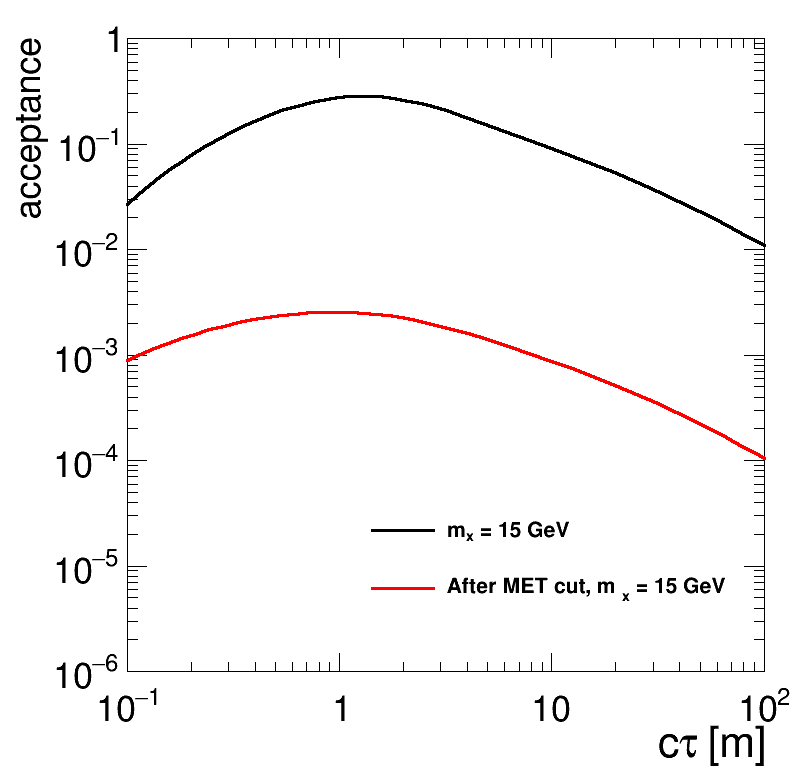

In [7]:
import os


leg = rt.TLegend(0.45,0.2,0.9,0.35)

leg.SetTextSize(0.030)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
c.SetRightMargin(0.04)


rt.gStyle.SetOptFit(1011)
h = {}
h_met = {}




for i, m in enumerate(mass):
    if not m == '15':continue
    var = acceptance
    y = [var['m'+m+'ctau100'], var['m'+m+'ctau1000'], var['m'+m+'ctau10000'], var['m'+m+'ctau100000']]
    x = np.array([int(a) for a in ctaus])
    h[m] = create_TGraph(x/1000, y,  axis_title=['c#tau [m]', 'acceptance'])

    var = accep_met
    y = [var['m'+m+'ctau100'], var['m'+m+'ctau1000'], var['m'+m+'ctau10000'], var['m'+m+'ctau100000']]
    x = np.array([int(a) for a in ctaus])
    h_met[m] = create_TGraph(x/1000, y,  axis_title=['c#tau [m]', 'acceptance'])


    h[m].SetLineColor(std_color_list[0])
    h[m].SetLineWidth(3)

    h_met[m].SetLineColor(std_color_list[1])
    h_met[m].SetLineWidth(3)
#     h_met[m].SetLineStyle(3)


    h[m].GetXaxis().SetTitleOffset(1)
    h[m].GetYaxis().SetTitleSize(0.05)
    h[m].GetYaxis().SetTitleOffset(1.5)

    h[m].GetXaxis().SetLimits(0.1,100.0)
    h[m].GetYaxis().SetRangeUser(0.000001,1)
    leg.AddEntry(h[m], "m_{x} = "+str(m)+" GeV", "L")
    leg.AddEntry(h_met[m], "After MET cut, m_{x} = "+str(m)+" GeV", "L")



for i,m in enumerate(h.keys()):
    h[m].Draw('CA' if i == 0 else 'Csame')
    h_met[m].Draw('Csame')


tdrstyle.setTDRStyle()
# CMS_lumi.cmsText     = "CMS"
# iPos = 0
# CMS_lumi.writeExtraText = True
# CMS_lumi.extraText   = "Preliminary"

# if( iPos==0 ): CMS_lumi.relPosX = 0.12
# CMS_lumi.CMS_lumi(c, 4, iPos)




leg.Draw()
c.SetLogy()
c.SetLogx()
c.SetTicky(1)
c.SetTickx(1)
# output_dir = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits/'+version+bdt_name+'/'+dc_version+'/unblindABC/'
# if not os.path.isdir(output_dir):os.makedirs(output_dir)
# name = output_dir+mode+'_HToSSTo'+decay+'_'+dphi+'_nRechit'+str(nrechit)



#         c.SaveAs(name+'.png')
#         c.SaveAs(name+'.C')
#         c.SaveAs(name+'.pdf')

c.Draw()

